Loading crops...:   0%|          | 0/1315 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/this_experiment/dataset.py:92: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525552843/work/torch/csrc/utils/tensor_numpy.cpp:199.)
  torch.from_numpy(


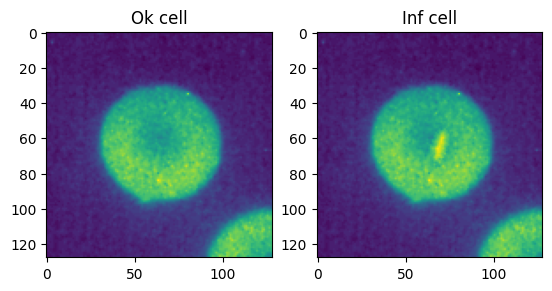

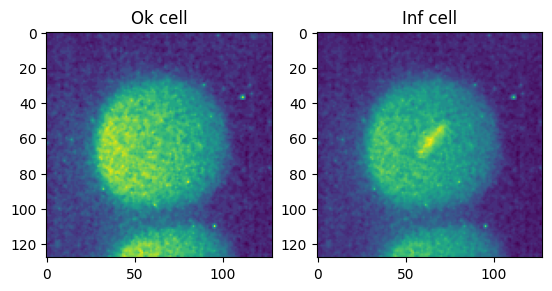

torch.Size([314])
torch.Size([614])
83.2**2 * RBF(length_scale=364)
GP On train set:  1.0
GP On test set:  0.9039087947882736
RF On train set:  1.0
RF On test set:  0.9055374592833876


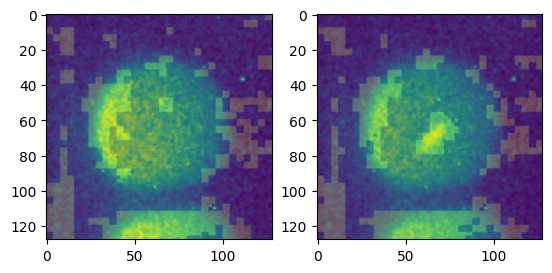

In [1]:
from this_experiment.models import CPFeatures
from this_experiment.dataset import CellCrops
from this_experiment.transforms import add_ellipse_random_placement

from pathlib import Path
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.gaussian_process.kernels import RBF, ConstantKernel
import torch

import matplotlib.pyplot as plt

# CellCrops class handles loading individual datapoints once given the location. It
# is designed to work with this dataset, so might not work for more general images. 
# It also loads all of the images into memory, so not good for large datasets. This 
# one is on the order of 100Mb big.
DSET_PATH = Path("/data/dataset/fl_dataset/healthy_train/raw")
dset = CellCrops(DSET_PATH, transforms=None, ext=None, load_to_gpu=None, set_size=128, debug=False)

# Load the network, requires that the cyto2 model is mounted inside the docker
# container. The size of the intermediate layers are hardcoded to match the shape
# of the pretrained model (taken from the Cellpose source code).
cp = CPFeatures([2, 32, 64, 128, 256], 3, 3, diam_mean=70, pretrained_path="/model/cyto2torch_0")
# Wrap the model and related transforms into a single function.
cp_transform = lambda img : cp((img / img.max())[None,].expand(-1,2,-1,-1))[0]

def subsample(X, m):
    r"""
    Selects a random subsample of the passed datapoints X. Used in the case where
    there is a large set of negative features (cell background / image background)
    to s. 
    
    Inputs:

        :X: (N_samples, N_features)

        :m: int

    Returns:
        (m, N_features)
    """
    N_samples = X.shape[0]
    sample_idxs = (torch.rand(m) * N_samples).floor().long()

    return X[sample_idxs]

    
def get_good_bad(img, same_location=True):
    r"""
    Sample pixel-wise datapoints.
    
        :img: (1,H,W) np.ndarray
        
        :same_location: bool, if True then the returned samples are of the same
            pixels where the artefact was added. Thus the sample is naturally 
            balanced.
    
    Returns
    
        X,y balanced dataset, where the negative samples have been subsampled if 
            same_location is set to False.
    """

    img_bad, mask_bad = add_ellipse_random_placement(img, (60,70), (60,70), (10,15), (5,10), (0, 1.6),
                                                    scale=100.)
    feats_bad = cp_transform(img_bad)[:,mask_bad].T
    if same_location:
        feats_ok =  cp_transform(img)[:,mask_bad].T
    else:
        feats_ok = subsample(cp_transform(img).flatten(start_dim=1).T, len(feats_bad))

    fig, axes = plt.subplots(1,2)
    axes[0].imshow(img[0] / img[0].max()); axes[0].set_title("Ok cell")
    axes[1].imshow(img_bad[0] / img_bad[0].max()); axes[1].set_title("Inf cell")
    plt.show()

    X = torch.cat([feats_ok, feats_bad], dim=0)
    y = torch.cat([torch.zeros(feats_ok.shape[0]),
                         torch.ones(feats_bad.shape[0])
                         ]).int()

    return X, y

def test_classifier_forward():
    r"""
    Performs a test where a healthy cell is sampled from the dataset and 
    an infected version is generated. The pixels at the location of the 
    generated parasite from both versions of the image are then selected
    and used to train a classifier. The classifier is then tested on a new
    sample and its infected version.
    """

    img_ok = dset[1]
    X_train, y_train = get_good_bad(img_ok)
    
    img_ok_test = dset[3]
    X_test, y_test = get_good_bad(img_ok_test)
    print(y_train.shape)
    print(y_test.shape)

    gp_clf = GaussianProcessClassifier(                    
                    ConstantKernel(1.0) * \
                    RBF(length_scale=5.0)
    )
    gp_clf.fit(X_train, y_train)
    print(gp_clf.kernel_)
    print("GP On train set: ", gp_clf.score(X_train, y_train))
    print("GP On test set: ", gp_clf.score(X_test, y_test))
    
    rf_clf = RandomForestClassifier()
    rf_clf.fit(X_train, y_train)
    print("RF On train set: ", rf_clf.score(X_train, y_train))
    print("RF On test set: ", rf_clf.score(X_test, y_test))
    
    fig, axes = plt.subplots(1,2)
    inp_ = cp_transform(dset[3])
    img_bad, _ = add_ellipse_random_placement(dset[3], (60,70), (60,70), (10,15), (5,10), (0, 1.6),
                                            scale=100.)
    inp_bad_ = cp_transform(img_bad)
    C, H, W = inp_.shape
    outp_viz = rf_clf.predict(inp_.flatten(start_dim=1).T).reshape(H,W)
    outp_viz_bad = rf_clf.predict(inp_bad_.flatten(start_dim=1).T).reshape(H,W)
    axes[0].imshow(outp_viz)
    axes[0].imshow(dset[3][0], alpha=0.8)
    axes[1].imshow(outp_viz_bad)
    axes[1].imshow(img_bad[0], alpha=0.8)

test_classifier_forward()
